In [ ]:
!git clone https://github.com/florent-leclercq/correlations_vs_field.git

Cloning into 'correlations_vs_field'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 124 (delta 26), reused 70 (delta 20), pack-reused 41
Receiving objects: 100% (124/124), 49.68 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
pip uninstall tensorflow -y -q

In [ ]:
pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
pip install tensorflow

     |████████████████████████████████| 454.3MB 35kB/s 
     |████████████████████████████████| 471kB 46.5MB/s 
     |████████████████████████████████| 1.2MB 34.7MB/s 
     |████████████████████████████████| 4.0MB 34.3MB/s 
     |████████████████████████████████| 4.0MB 39.3MB/s 
     |████████████████████████████████| 6.0MB 30.9MB/s 
     |████████████████████████████████| 4.9MB 27.7MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Succe

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import tqdm.auto as tqdm
from PIL import Image, ImageOps
rng = jax.random.PRNGKey(2)

In [ ]:
tfp.__version__

'0.14.0-dev20210518'

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
N=20
Nsq = N**2
θ_fid = np.array([1.0, 0.5], dtype='float64')

In [ ]:
r2 = np.tile(
    np.abs(
        np.expand_dims(np.arange(N, dtype=np.float64), 0) 
        - np.expand_dims(np.arange(N, dtype=np.float64), 1)), 
    (N, N)) ** np.float64(2.) + \
    np.abs(
        np.expand_dims(np.repeat(np.arange(N, dtype=np.float64), N), 0)
        - np.expand_dims(np.repeat(np.arange(N, dtype=np.float64), N), 1)) ** np.float64(2.)
def ξ_G(β):
    return np.exp(
        -np.expand_dims(r2, tuple(np.arange(β.ndim))) 
        / 4. / np.expand_dims(β**2., (-2, -1)))

In [ ]:
def dξdβ(β):
    return 0.5 * r2 *(1./β**3)* np.exp(-0.25 * r2 * (1/β)**2)
def known_fisher(θ, Nsq):
    α,β = θ
    # get covariance
    _ξ    = ξ_G(β)
    # get derivative
    dξ_dβ   = dξdβ(β) 
    
    Cinv = np.linalg.inv(_ξ)        
    
    # fisher matrix entries
    Faa = 2*Nsq / α**2
    Fab = (1. / α) * np.trace(Cinv @ dξ_dβ)
    Fba = Fab
    Fbb = 0.5 * np.trace(Cinv @ dξ_dβ @ Cinv  @ dξ_dβ)

    return np.array([[Faa, Fab], [Fba, Fbb]])

In [ ]:
f = known_fisher(θ_fid, Nsq)

analytic_detF = np.linalg.det(f)
print('F from analytic derivation : ', f)
print('detF from analytic derivation : ', analytic_detF)

F from analytic derivation :  [[  800.         -1215.26943272]
 [-1215.26943272  5815.55875945]]
detF from analytic derivation :  3175567.2134655886


In [ ]:
def _f_NL(α, β):
    return tfd.TransformedDistribution(
      distribution=tfd.MultivariateNormalTriL(
          loc=np.zeros((N**2,)),
          scale_tril=np.linalg.cholesky(ξ_G(β))),
      bijector= tfb.Chain([
          tfb.Exp(),
          tfb.AffineScalar(
              #shift=-0.5 * np.expand_dims(α, -1)**2.,
              scale=np.expand_dims(α, -1))]))

def loglike(α, β, key):
    f_NL = _f_NL(α, β)
    return f_NL.log_prob(f_NL.sample(seed=key))

@jax.jit
def dlnLdθ(α, β, key):
    return jax.grad(loglike, argnums=(0, 1))(α, β, key)

def numeric_F(α, β, key, n_samples):
    keys = np.array(jax.random.split(key, num=n_samples))
    return np.cov(np.array(jax.vmap(dlnLdθ)(np.repeat(α, n_samples), np.repeat(β, n_samples), keys)), rowvar=True)

In [ ]:
def hessian_F(α, β, key, n_samples):
    keys = jax.random.split(key, num=n_samples)

    # Compile a function that computes the Hessian of the likelihood
    hessian_loglik = jax.jit(jax.hessian(loglike, argnums=(0,1)))

    # Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
    
    return np.mean(np.array([hessian_loglik(α, β, k) for k in keys]), axis=0)

In [ ]:
rng, key = jax.random.split(rng)
_a,_b = θ_fid
#F_expected = #np.mean(np.array([numeric_F(np.array(_a), np.array(_b), key, 20)
              #                  for i in range(10)
               #                   ]), axis=0)

F_expected = np.mean(np.array([numeric_F(np.array(_a), 
                                         np.array(_b), key, 1000) for i in range(10)]), axis=0)
detF_expected = np.linalg.det(F_expected)

print('F from numerical covariance: ', F_expected)
print('det F from covariance: ', (detF_expected))

F from numerical covariance:  [[1242.24641197 2385.92189992]
 [2385.92189992 4776.29047434]]
det F from covariance:  240706.39174016644


In [ ]:
rng, key = jax.random.split(rng)

F_hess = hessian_F(_a, _b, key, 500)
detF_hessian = np.linalg.det(F_hess)
print('hessian F: ', F_hess)
print('hessian det F: ', (detF_hessian))

hessian F:  [[ 400.           -5.66297911]
 [  -5.66297911 3133.72240919]]
hesiian det F:  1253456.8943422867


In [ ]:
detF_hessian / analytic_detF

DeviceArray(0.39471906, dtype=float64)

In [ ]:
detF_expected / analytic_detF

DeviceArray(0.08603857, dtype=float64)

In [ ]:
def simulator(rng, n, 
        α, β, μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    dist = tfd.TransformedDistribution(
        #distribution=tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalTriL(
                loc=μ, 
                scale_tril=tfp.math.fill_triangular(σ) 
                    * np.linalg.cholesky(ξ_G(β))),
        #     #bijector=tfb.Reshape((N, N))),
        # bijector=tfb.Chain([
        #     tfb.Scale(np.expand_dims(α, (-1))),
        #     tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
        #     tfb.Exp(),
        #     tfb.Shift(-np.float64(1.)),
        #     tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1)))]
        #     ))
              bijector=tfb.Chain([
                    tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float64(0.5) * np.expand_dims(α, -1)**np.float64(2.), scale=np.expand_dims(α, -1))]))

    if n is not None:
        return dist.sample(n, seed=rng)
    else: 
        return dist.sample(seed=rng)

In [ ]:
def _f_NL1(
        _α, _β, 
        μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
            β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(_β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.float64(1.) / np.expand_dims(_α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float64(0.5) * np.expand_dims(_α, -1)**np.float64(2.), scale=np.expand_dims(_α, -1))]))))

In [ ]:
def _f_NL(
        α, β, 
        μ=np.zeros((N**2,), dtype=np.float64), 
        σ=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)):
    return tfd.JointDistributionNamed(
        dict(
            α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
            β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
            f_NL = tfd.TransformedDistribution(
                #distribution=tfd.TransformedDistribution(
                    distribution=tfd.MultivariateNormalTriL(
                        loc=μ, 
                        scale_tril=tfp.math.fill_triangular(σ) 
                            * np.linalg.cholesky(ξ_G(β))),
                    #bijector=tfb.Reshape((N, N))),
                bijector=tfb.Chain([
                    tfb.Scale(np.expand_dims(α, (-1))),
                    tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
                    tfb.Exp(),
                    tfb.Shift(-np.float64(1.)),
                    tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1)))]))))

In [ ]:
f_NL = tfd.JointDistributionNamed(
    dict(
        α = tfd.Uniform(low=np.float64(0.), high=np.float64(2.)),
        β = tfd.Uniform(low=np.float64(0.2), high=np.float64(0.8)),
        μ = tfd.Normal(
            loc=np.zeros((N**2,), dtype=np.float64), 
            scale=np.ones((N**2,), dtype=np.float64)),                 
        σ = tfp.distributions.Uniform(
            low=np.zeros((N**2 * (N**2 + 1) // 2,), dtype=np.float64), 
            high=np.ones((N**2 * (N**2 + 1) // 2,), dtype=np.float64)),
        f_NL = lambda α, β, μ, σ: tfd.TransformedDistribution(
            #distribution=tfd.TransformedDistribution(
                distribution=tfd.MultivariateNormalTriL(
                    loc=μ, 
                    scale_tril=tfp.math.fill_triangular(σ) 
                        * np.linalg.cholesky(ξ_G(β))),
                #bijector=tfb.Reshape((N, N))),
            # bijector=tfb.Chain([
            #     tfb.Scale(np.expand_dims(α, (-1))),
            #     tfb.Shift(-np.float64(0.5) * np.expand_dims(α, (-1))**np.float64(2.)),
            #     tfb.Exp(),
            #     tfb.Shift(-np.float64(1.)),
            #     tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1)))]
            #     ))))
            bijector=tfb.Chain([
                    tfb.Scale(np.float64(1.) / np.expand_dims(α, (-1))),
                    tfb.Expm1(),
                    tfb.AffineScalar(shift=-np.float64(0.5) * np.expand_dims(α, -1)**np.float64(2.), scale=np.expand_dims(α, -1))]))))


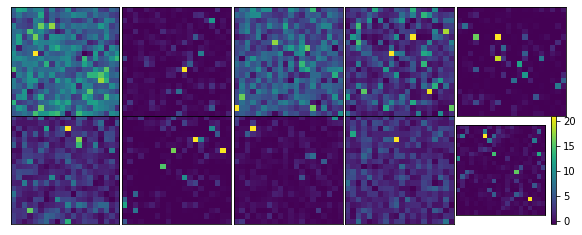

In [ ]:
rng, key = jax.random.split(rng)
f_NLs = f_NL.sample(10, seed=key)["f_NL"].reshape((10, N, N))
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(2):
    for j in range(5):
        a = ax[i, j].imshow(f_NLs[j + i * 5])
        ax[i, j].set(xticks=[], yticks=[])
plt.colorbar(a)

In [ ]:
rng, key = jax.random.split(rng)
target = dict(
    f_NL=None,
    α=np.array(1.0),
    β=np.array(0.5))
target["f_NL"] = simulator(key, None, target["α"], target["β"])

# target data from Florent's analysis

In [ ]:
dataid = 1

In [ ]:
import numpy as onp
dat = np.load("correlations_vs_field/data/Sims20_05_10_80_80_500_80_1_123456.npy")
target['f_NL'] = dat[dataid]['field'].flatten()

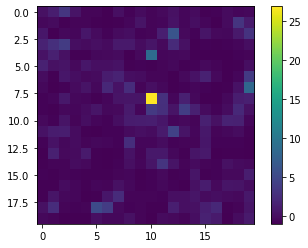

In [ ]:
plt.imshow(target["f_NL"].reshape(N,N))
plt.colorbar()

In [ ]:
size = 250
marginal = np.ones((size, size)) * np.nan
bar = tqdm.tqdm(np.linspace(0., 2., size))
for a, _α in enumerate(bar):
    if a != 0 and _α < 2.:
        marginal = jax.ops.index_update(
            marginal, 
            jax.ops.index[a], 
            _f_NL1(np.repeat(_α, size), np.linspace(0.2, 0.8, size)).prob(target))
        bar.set_postfix(a=a, α=_α)

RuntimeError: ignored

In [ ]:
arr = marginal[~np.isnan(marginal)]
inds = np.argsort(arr)[::-1]
cdf = np.cumsum(arr[inds] / arr.sum())
levels = [arr[inds[np.argmin(np.abs(i - cdf))]] for i in [0.99, 0.95, 0.68, 0.]]

DeviceArray(nan, dtype=float64)

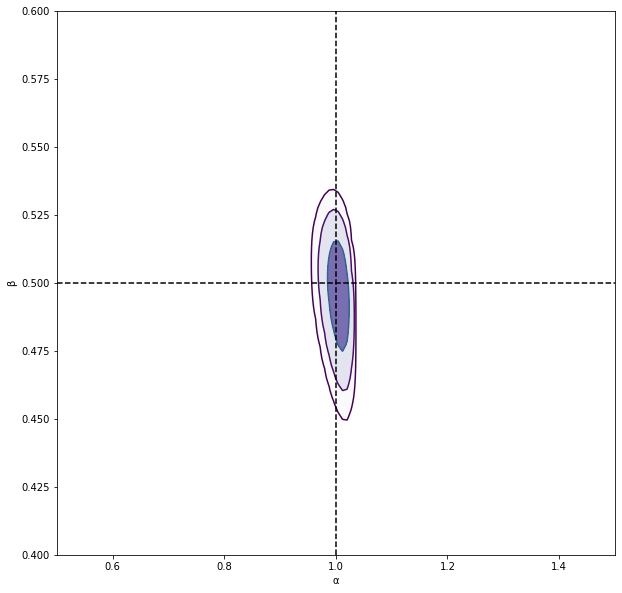

In [ ]:
plt.figure(figsize=(10, 10))
plt.contourf(np.linspace(0., 2., size), np.linspace(0.2, 0.8, size), marginal.T, levels=levels, cmap="Purples")
plt.contour(np.linspace(0., 2., size), np.linspace(0.2, 0.8, size), marginal.T, levels=levels)
plt.xlabel("α")
plt.ylabel("β")
plt.ylim(0.4, 0.6)
plt.xlim(0.5, 1.5)
plt.axvline(target["α"], linestyle="dashed", color="black")
plt.axhline(target["β"], linestyle="dashed", color="black");
plt.savefig("BHM_field_%d.svg"%(dataid), bbox_inches="tight", transparent=True)

In [ ]:
np.save('marginal_field_%d_20x20_field'%(dataid), marginal.T)